# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [2]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [3]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs
        
if not os.path.exists('tables'):
    !mkdir tables

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate, savefig, write_table

## Outer operations

Many useful operations can be expressed in the form of an "outer operation" of two sequences.
Suppose you have sequences like `t1` and `t2`:

In [5]:
t1 = [1,3,5]

In [6]:
t2 = [2,4]

The most common outer operation is the outer product, which computes the product of every pair of values, one from each sequence.

For example, here is the outer product of `t1` and `t2`:

In [7]:
a = np.multiply.outer(t1, t2)
a

array([[ 2,  4],
       [ 6, 12],
       [10, 20]])

We can understand this result more easily if we put it in a DataFrame:

In [8]:
df = pd.DataFrame(a, index=t1, columns=t2)
write_table(df, 'table09-01', bold_rows=True)
df

,2,4
1,2,4
3,6,12
5,10,20


The values from `t1` appear along the rows of the result; the values from `t2` appear along the columns.  

Each element of the result is the product of an element from `t1` and an element from `t2`.

The outer sum is similar, except that each element is the *sum* of an element from `t1` and an element from `t2`.

In [9]:
a = np.add.outer(t1, t2)
a

array([[3, 5],
       [5, 7],
       [7, 9]])

In [10]:
df = pd.DataFrame(a, index=t1, columns=t2)
write_table(df, 'table09-02', bold_rows=True)
df

,2,4
1,3,5
3,5,7
5,7,9


These outer operations work with Python lists and tuples, and NumPy arrays, but not Pandas Series.

However, the following function works with Pandas Series and puts the result into a DataFrame.

In [11]:
def outer_product(s1, s2):
    """Compute the outer product of two Series.
    
    First Series goes down the rows;
    second goes across the columns.
    
    s1: Series
    s2: Series
    
    return: DataFrame
    """
    a = np.multiply.outer(s1.to_numpy(), s2.to_numpy())
    return pd.DataFrame(a, index=s1.index, columns=s2.index)

It might not be obvious yet why these operations are useful, but we'll see some examples soon.

With that, we are ready to take on a new Bayesian problem.

## How tall is A?

Suppose I choose two people from the population of adult males in the U.S.; I'll call them A and B.  If we see that A taller than B, how tall is A?

To answer this question:

1. I'll use background information about the height of men in the U.S. to form a prior distribution of height,

2. I'll construct a joint distribution of height for A and B (and I'll explain what that is);

3. Then I'll update the prior with the information that A is taller, and 

4. From the posterior joint distribution I'll extract the posterior distribution of height for A.

In the U.S. the average height of male adults in 178 cm and the standard deviation is 7.7 cm.  The distribution is not exactly normal, because nothing in the real world is, but the normal distribution is a pretty good model of the actual distribution, so we can use it as a prior distribution for A and B.

Here's an array of equally-spaced values from roughly 3 standard deviations below the mean to 3 standard deviations above.

In [12]:
mean = 178
std = 7.7

qs = np.arange(mean-24, mean+24, 0.5)

SciPy provides a function called `norm` that represents a normal distribution with a given mean and standard deviation, and provides `pdf`, which evaluates the probability distribution function (PDF), which we will use as the prior probabilities.

In [13]:
from scipy.stats import norm

ps = norm(mean, std).pdf(qs)

I'll store the `ps` and `qs` in a `Pmf` that represents the prior distribution.

In [14]:
prior = Pmf(ps, qs)
prior.normalize()

1.9963309462450582

And here's what it looks like.

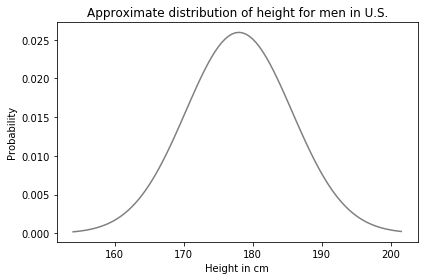

In [15]:
prior.plot(color='gray')

decorate(xlabel='Height in cm',
         ylabel='Probability',
         title='Approximate distribution of height for men in U.S.')

This distribution represents what we believe about the heights of `A` and `B` before we take into account the data that `A` is taller.

## Joint distribution

The next step is to construct a distribution that represents the probability of every pair of heights, which is called a joint distribution.  
The elements of the joint distribution are

$P(A_y~\mathrm{and}~B_x)$

which is the probability that `A` is $y$ cm tall and `B` is $x$ cm tall, for all values of $y$ and $x$.

At this point all we know about `A` and `B` is that they are male residents of the U.S., so their heights are independent; that is, knowing the height of `A` provides no additional information about the height of `B`.
In that case, we can compute the joint probabilities like this:

$P(A_y~\mathrm{and}~B_x) = P(A_y)~P(B_x)$

Each joint probability is the product of one element from the distribution for `A` and one element from the distribution for `B`.
So we can compute the joint distribution using `outer_product`:

In [16]:
joint = outer_product(prior, prior)
joint.shape

(96, 96)

The result is a `DataFrame` with possible heights of `A` along the rows, heights of `B` along the columns, and the joint probabilities as elements.

If the prior is normalized, the joint prior should also be normalized.

In [17]:
joint.to_numpy().sum()

1.0

Notice that we have to convert the `DataFrame` to a `NumPy` array before calling `sum`.  Otherwise, `DataFrame.sum` would compute the sums of the columns and return a `Series`.

In [18]:
joint.sum()

154.0    0.000202
154.5    0.000246
155.0    0.000300
155.5    0.000363
156.0    0.000438
           ...   
199.5    0.000526
200.0    0.000438
200.5    0.000363
201.0    0.000300
201.5    0.000246
Length: 96, dtype: float64

## Visualizing the joint distribution

The following function uses `pcolormesh` to plot the joint distribution.

Recall that `outer_product` puts the values of `A` along the rows and the values of `B` across the columns.

In [19]:
def plot_joint(joint):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    plt.pcolormesh(joint.columns, joint.index, joint, cmap='Blues')
    plt.colorbar()
    decorate(ylabel='A height in cm',
             xlabel='B height in cm')

And here's what the result looks like.

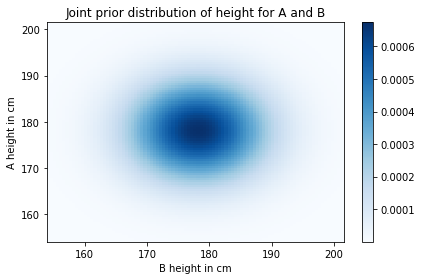

In [20]:
plot_joint(joint)
decorate(title='Joint prior distribution of height for A and B')
savefig('fig09-01')

As you might expect, the probability is highest near the mean and drops off away from the mean.

Another way to visualize the joint distribution is a contour plot.

In [21]:
def plot_contour(joint):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    plt.contour(joint.columns, joint.index, joint)
    plt.ylabel('A height in cm')
    plt.xlabel('B height in cm')

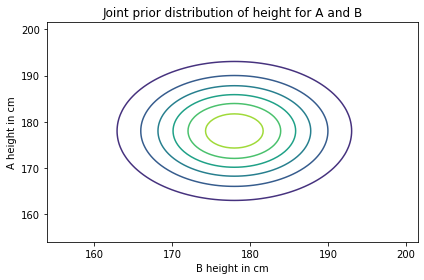

In [22]:
plot_contour(joint)
decorate(title='Joint prior distribution of height for A and B')

Each circle represents a level of equal probability.  

## Likelihood

Now that we have a joint prior distribution, we can update it with the data, which is that `A` is taller than `B`.

Each element in the joint distribution represents a hypothesis about the heights of `A` and `B`; for example:

* The element `(180, 170)` represents the hypothesis that `A` is 180 cm tall and `B` is 170 cm tall.  Under this hypothesis, the probability that `A` is taller than `B` is 1.

* The element `(170, 180)` represents the hypothesis that `A` is 170 cm tall and `B` is 180 cm tall.  Under this hypothesis, the probability that `A` is taller than `B` is 0.

To compute the likelihood of every pair of values, we can extract the values from the prior, like this:

In [23]:
Y = joint.index.to_numpy()
X = joint.columns.to_numpy()

And then apply the `outer` version of `np.subtract`, which computes the difference between every element of `Y` (height of `A`) and every element of `X` (height of `B`).

In [24]:
diff = np.subtract.outer(Y, X)

The result is an array of differences.  To compute likelihoods, we use `np.where` which puts `1` where the `diff` is greater than 0 and 0 elsewhere.

In [25]:
a = np.where(diff>0, 1, 0)

The result is an array of likelihoods, which I will put in a `DataFrame` with the values of `Y` in the index and the values of `X` in the columns.

In [26]:
likelihood = pd.DataFrame(a, index=Y, columns=X)

Here's what it looks like:

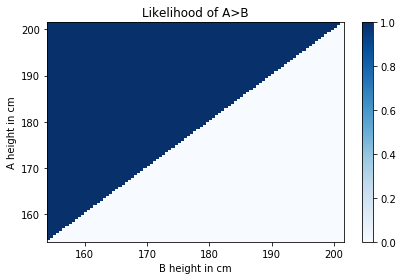

In [27]:
plot_joint(likelihood)
decorate(title='Likelihood of A>B')
savefig('fig09-02')

The likelihood of the data is 1 where `Y>X` and 0 elsewhere.

## The update

We have a prior, we have a likelihood, and we are ready for the update.  As usual, the unnormalized posterior is the product of the prior and the likelihood.

In [28]:
posterior = joint * likelihood

I'll use the following function to normalize the posterior:

In [29]:
def normalize(joint):
    """Normalize a joint distribution.
    
    joint: DataFrame
    """
    prob_data = joint.to_numpy().sum()
    joint /= prob_data

In [30]:
normalize(posterior)

Here's what it looks like.

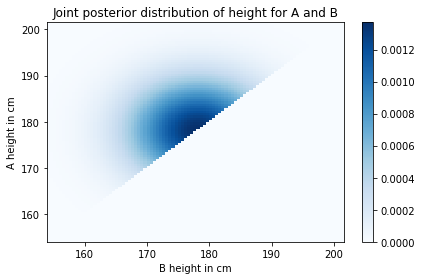

In [31]:
plot_joint(posterior)
decorate(title='Joint posterior distribution of height for A and B')
savefig('fig09-03')

## The marginals

The joint posterior distribution represents what we believe about the heights of `A` and `B`, given the prior distributions and the information that `A` is taller.

From this joint distribution, we can compute the posterior distributions for `A` and `B`.  To see how, let's start with a simpler problem.

Suppose we want to know the probability that `B` is 180 cm tall.  We can select the column from the joint distribution where `X=180`.

In [32]:
column = posterior[180]

This column contains posterior probabilities for all cases where `X=180`; if we add them up, we get the total probability that `B` is 180 cm tall.

In [33]:
column.sum()

0.019669089649708035

Now, to get the posterior distribution of height for `B`, we can add up all of the columns, like this:

In [34]:
column_sums = posterior.sum(axis=0)
column_sums

154.0    4.107818e-04
154.5    5.017502e-04
155.0    6.102524e-04
155.5    7.390480e-04
156.0    8.911932e-04
             ...     
199.5    1.444700e-06
200.0    8.115722e-07
200.5    4.040531e-07
201.0    1.504623e-07
201.5    0.000000e+00
Length: 96, dtype: float64

The argument `axis=0` means we want to sum the elements along the rows; that is, we want to add up the columns.

The result is a `Series` that contains every possible height for `B` and its probability.  In other words, it is the distribution of heights for `B`.

We can put it in a `Pmf` like this:

In [35]:
marginal_B = Pmf(column_sums)

When we extract the distribution of a single variable from a joint distribution, the result is called a marginal distribution.
The name comes from a common visualization that shows the joint distribution in the middle and the marginal distributions in the margins.

Here's what the marginal distribution for `B` looks like:

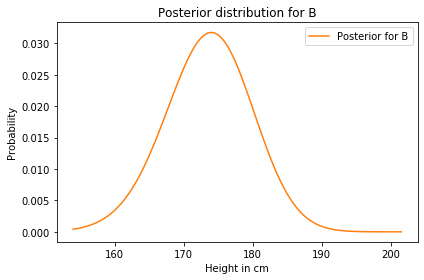

In [36]:
marginal_B.plot(label='Posterior for B', color='C1')

decorate(xlabel='Height in cm',
         ylabel='Probability',
         title='Posterior distribution for B')

Similarly, we can get the posterior distribution of height for `A` by adding up the rows and putting the result in a `Pmf`.

In [37]:
row_sums = posterior.sum(axis=1)
marginal_A = Pmf(row_sums)

Here's what it looks like.

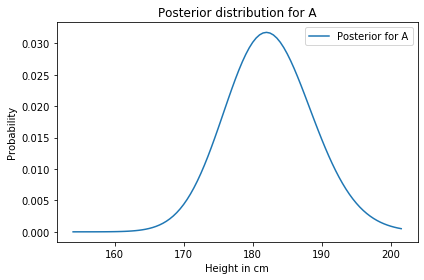

In [38]:
marginal_A.plot(label='Posterior for A')

decorate(xlabel='Height in cm',
         ylabel='Probability',
         title='Posterior distribution for A')

The following function takes a joint distribution and an axis number, and returns a marginal distribution.

In [39]:
def marginal(joint, axis):
    """Compute a marginal distribution.
    
    axis=1 returns the marginal distribution of the first variable
    axis=0 returns the marginal distribution of the second variable
    
    joint: DataFrame representing a joint distribution
    axis: int axis to sum along
    
    returns: Pmf
    """
    return Pmf(joint.sum(axis=axis))

In [40]:
marginal_B = marginal(posterior, axis=0)
marginal_A = marginal(posterior, axis=1)

Here's what they look like.

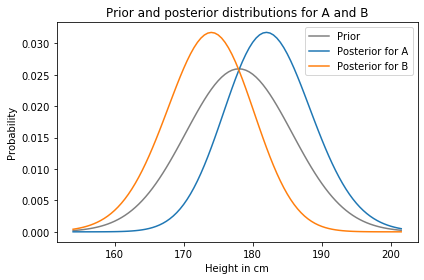

In [41]:
prior.plot(label='Prior', color='gray')
marginal_A.plot(label='Posterior for A')
marginal_B.plot(label='Posterior for B')

decorate(xlabel='Height in cm',
         ylabel='Probability',
         title='Prior and posterior distributions for A and B')
savefig('fig09-04')

As you might expect, the posterior distribution for `A` is shifted to the right and the posterior distribution for `B` is shifted to the left.

We can summarize the results by computing the posterior means:

In [42]:
prior.mean()

177.99516026921506

In [43]:
marginal_A.mean(), marginal_B.mean()

(182.38728123421686, 173.60286000233387)

Based on the observation that `A` is taller than `B`, we are inclined to believe that `A` is a little taller than average, and `B` is a little shorter.

Notice that the posterior distributions are a little narrower than the prior.  We can quantify that by computing their standard deviations.

In [44]:
prior.std()

7.624924796641578

In [45]:
marginal_A.std(), marginal_B.std()

(6.27046117764547, 6.280513548175111)

The standard deviations of the posterior distributions are a little smaller, which means we are a little more certain about the heights of `A` and `B` after we compare them.

## Conditional posteriors

Now suppose we measure `B` and find that he is 180 cm tall.  What does that tell us about `A`?

In the joint distribution, each column corresponds a possible height for `B`.  We can select the column that corresponds to height 180 cm like this:

In [46]:
column_180 = posterior[180]

The result is a `Series` that represents possible heights for `A` and their relative likelihoods.
These likelihoods are not normalized, but we can normalize them like this:

In [47]:
cond_A = Pmf(column_180)
cond_A.normalize()

0.019669089649708035

Note that when we make a `Pmf` it copies the data by default, so we can modify `cond_A` without affecting `column_180` or `posterior`.

The result is the conditional distribution of height for `A` given that `B` is 180 cm tall.

Here's what it looks like:

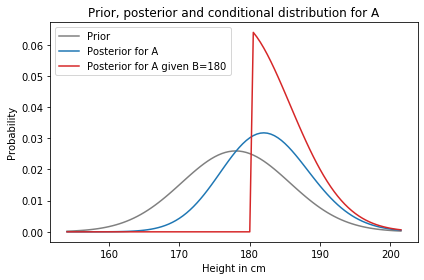

In [48]:
prior.plot(label='Prior', color='gray')
marginal_A.plot(label='Posterior for A')
cond_A.plot(label='Posterior for A given B=180', color='C3')

decorate(xlabel='Height in cm',
         ylabel='Probability',
         title='Prior, posterior and conditional distribution for A')
savefig('fig09-05')

The posterior conditional distribution is cut off at 180 cm, because we have established that `A` is taller than `B` and `B` is 180 cm.
And the mean of the conditional distribution is a few centimeters higher:

In [49]:
marginal_A.mean(), cond_A.mean()

(182.38728123421686, 185.59735919788176)

## Dependence and independence

When we constructed the joint prior distribution, I said that the heights of `A` and `B` were independent, which means that knowing one of them provides no information about the other.
In other words, the conditional probability $P(A_y | B_x)$ is the same as the unconditioned probability $P(A_y)$.

That's why we can compute an element of the joint prior, $P(A_y~\mathrm{and}~B_x)$, by rewriting it in terms of conditional probability, $P(B_x)~P(A_y~|~B_x)$, and using the independence of $A$ and $B$ to replace the conditional probability.

Putting it all together, we have

$P(A_y~\mathrm{and}~B_x) = P(B_x)~P(A_y)$

But remember, that's only true if $A$ and $B$ are independent.  
In the posterior distribution, they are not.  
We know that `A` is taller than `B`, so if we know how tall `B` is, that gives us information about `A`.

The conditional distribution we just computed demonstrates this dependence.

## Exercises

**Exercise:** Based on the results of the previous example, compute the posterior conditional distribution for `B` given that `A` is 190 cm.

Hint: Use `loc` to select a row from a `DataFrame`.

In [50]:
row_190 = posterior.loc[190]
cond_B = Pmf(row_190)
cond_B.normalize()

0.014717007072550579

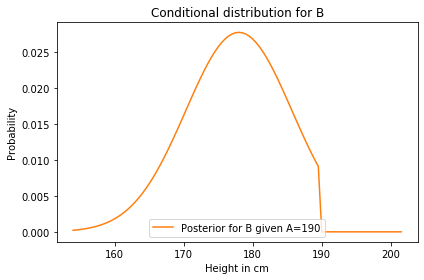

In [73]:
cond_B.plot(label='Posterior for B given A=190', color='C1')
decorate(xlabel='Height in cm',
         ylabel='Probability',
         title='Conditional distribution for B')

**Exercise:** Suppose we have established that `A` is taller than `B`, but we don't know how tall `B` is.
Now we choose a random woman, `C`, and find that she is shorter than `A` by at least 15 cm.  Compute posterior distributions for the heights of `A` and `C`.

The average height for women in the U.S. is 163 cm; the standard deviation is 7.3 cm. 

In [52]:
# Solution

mean = 163
std = 7.3

qs = np.arange(mean-24, mean+24, 0.5)
ps = norm(mean, std).pdf(qs)

prior_C = Pmf(ps, qs)
prior_C.normalize()

1.997970387889823

In [53]:
# Solution

joint_AC = outer_product(marginal_A, prior_C)
joint_AC.shape

(96, 96)

In [54]:
# Solution

Y = joint_AC.index.to_numpy()
X = joint_AC.columns.to_numpy()
diff = np.subtract.outer(Y, X)
a = np.where(diff>=15, 1, 0)
likelihood_AC = pd.DataFrame(a, index=Y, columns=X)

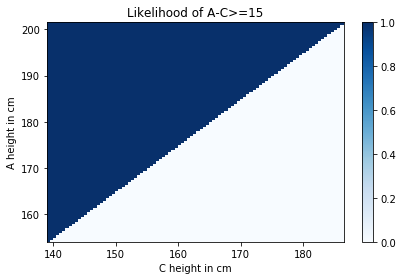

In [55]:
# Solution

plot_joint(likelihood_AC)
decorate(xlabel='C height in cm',
         title='Likelihood of A-C>=15')

In [56]:
# Solution

posterior_AC = joint_AC * likelihood_AC
normalize(posterior_AC)

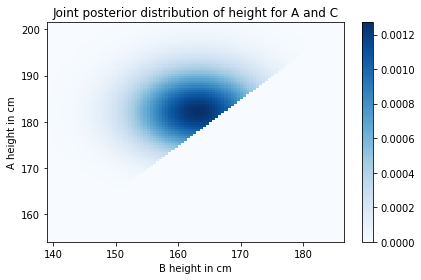

In [57]:
# Solution

plot_joint(posterior_AC)
decorate(title='Joint posterior distribution of height for A and C')

In [58]:
# Solution

marginal_C = marginal(posterior_AC, axis=0)
marginal_AC = marginal(posterior_AC, axis=1)

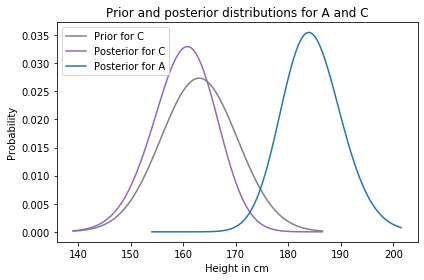

In [59]:
# Solution

prior_C.plot(label='Prior for C', color='gray')
marginal_C.plot(label='Posterior for C', color='C4')
marginal_AC.plot(label='Posterior for A', color='C0')

decorate(xlabel='Height in cm',
         ylabel='Probability',
         title='Prior and posterior distributions for A and C')

**Exercise:** [The Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system) is a way to quantify the skill level of players for games like chess.

It is based on a model of the relationship between the ratings of players and the outcome of a game.  Specifically, if $R_A$ is the rating of player `A` and $R_B$ is the rating of player `B`, the probability that `A` beats `B` is given by the [logistic function](https://en.wikipedia.org/wiki/Logistic_function):

$P(\mathrm{A~beats~B}) = 1 / (1 + 10^{(R_B-R_A)/400})$

The parameters $10$ and $400$ are arbitrary choices that determine the range of the ratings.  In chess, the range is from 100 to 2800.

Notice that the probability of winning depends only on the difference in rankings.  As an example, if $R_A$ exceeds $R_B$ by 100 points, the probability that `A` wins is

In [60]:
1 / (1 + 10**(-100/400))

0.6400649998028851

Suppose `A` has a current rating of 1600, but we are not sure it is accurate.  We could describe their true rating with a normal distribution with mean 1600 and standard deviation 100, to indicate our uncertainty.

And suppose `B` has a current rating of 1800, with the same level of uncertainty.

Then `A` and `B` play and `A` wins.  How should we update their ratings?

To answer this question:

1. Construct prior distributions for `A` and `B`.

2. Use them to construct a joint distribution, assuming that the prior distributions are independent.

3. Use the logistic function above to compute the likelihood of the outcome under each joint hypothesis.  

4. Use the joint prior and likelihood to compute the joint posterior. 

5. Extract and plot the marginal posteriors for `A` and `B`.

6. Compute the posterior means for `A` and `B`.  How much should their ratings change based on this outcome?

In [61]:
# Solution

qs = np.arange(1300, 1900, 10)
ps = norm(1600, 100).pdf(qs)
prior_A = Pmf(ps, qs)
prior_A.normalize()

qs = np.arange(1500, 2100, 10)
ps = norm(1800, 100).pdf(qs)
prior_B = Pmf(ps, qs)
prior_B.normalize()

0.09972780668486173

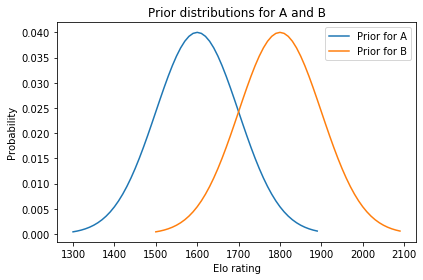

In [62]:
# Solution

prior_A.plot(label='Prior for A')
prior_B.plot(label='Prior for B')

decorate(xlabel='Elo rating',
         ylabel='Probability',
         title='Prior distributions for A and B')

In [63]:
# Solution

joint_elo = outer_product(prior_A, prior_B)
joint_elo.shape

(60, 60)

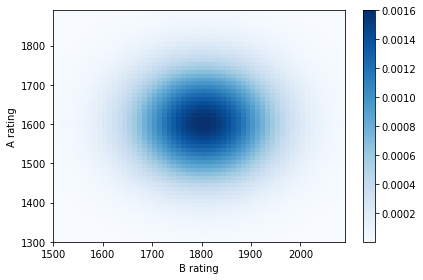

In [64]:
# Solution

plot_joint(joint_elo)
decorate(ylabel='A rating',
         xlabel='B rating')

In [65]:
# Solution

Y = joint_elo.index.to_numpy()
X = joint_elo.columns.to_numpy()

diff = np.subtract.outer(Y, X)

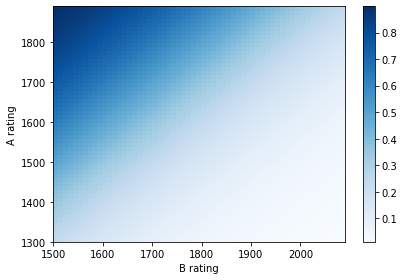

In [66]:
# Solution

a = 1 / (1 + 10**(-diff/400))
likelihood_elo = pd.DataFrame(a, index=Y, columns=X)

plot_joint(likelihood_elo)   
decorate(ylabel='A rating',
         xlabel='B rating')

In [67]:
# Solution

posterior_elo = joint_elo * likelihood_elo
normalize(posterior_elo)

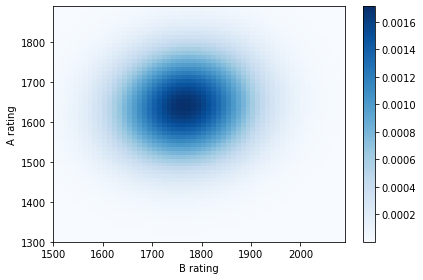

In [68]:
# Solution

plot_joint(posterior_elo)   
decorate(ylabel='A rating',
         xlabel='B rating')

In [69]:
# Solution

marginal_B = marginal(posterior_elo, axis=0)
marginal_A = marginal(posterior_elo, axis=1)

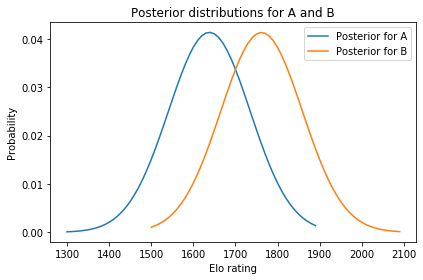

In [70]:
# Solution

marginal_A.plot(label='Posterior for A')
marginal_B.plot(label='Posterior for B')

decorate(xlabel='Elo rating',
         ylabel='Probability',
         title='Posterior distributions for A and B')

In [71]:
# Solution

marginal_A.mean(), marginal_B.mean()

(1636.648345528236, 1763.0203078793095)

In [72]:
# Solution

marginal_A.std(), marginal_B.std()

(95.34063582447712, 95.61569535990881)

## Summary

In this notebook I started with the "outer" operations, like outer product, which we used to construct a joint distribution.

In general, you cannot construct a joint distribution from two marginal distributions, but in the special case where the distributions are independent, you can.

We extended the Bayesian update process we've seen in previous notebooks and applied it to a joint distribution.  Then from the posterior joint distribution we extracted posterior marginal distributions and posterior conditional distributions.

As an exercise, you had a chance to apply the same process to a slightly more difficult problem, updating Elo ratings based on the outcome of a chess game.